**Big Data Analysis using PySpark on NYC Taxi (Jan 2015)**

**Introduction / Objective**

Analyze NYC Taxi Data using PySpark to demonstrate scalable data processing.

In [1]:
# pip install pyspark


**Load the CSV file**

In [9]:
data = spark.read.csv("/content/yellow_tripdata_2015-01.csv",header=True, inferSchema=True)

data.printSchema()
data.show(5)


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+------------------+---------------

In [17]:
df_cleaned = data.select("tpep_pickup_datetime", "total_amount", "passenger_count") \
               .dropna()
df_cleaned.show(5)
df_cleaned.printSchema()


+--------------------+------------+---------------+
|tpep_pickup_datetime|total_amount|passenger_count|
+--------------------+------------+---------------+
| 2015-01-15 19:05:39|       17.05|              1|
| 2015-01-10 20:33:38|        17.8|              1|
| 2015-01-10 20:33:38|        10.8|              1|
| 2015-01-10 20:33:39|         4.8|              1|
| 2015-01-10 20:33:39|        16.3|              1|
+--------------------+------------+---------------+
only showing top 5 rows

root
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



**Feature Engineering: Pickup Hour**

In [19]:
from pyspark.sql.functions import hour, col

df_with_hour = df_cleaned.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))
df_with_hour.show(5)




+--------------------+------------+---------------+-----------+
|tpep_pickup_datetime|total_amount|passenger_count|pickup_hour|
+--------------------+------------+---------------+-----------+
| 2015-01-15 19:05:39|       17.05|              1|         19|
| 2015-01-10 20:33:38|        17.8|              1|         20|
| 2015-01-10 20:33:38|        10.8|              1|         20|
| 2015-01-10 20:33:39|         4.8|              1|         20|
| 2015-01-10 20:33:39|        16.3|              1|         20|
+--------------------+------------+---------------+-----------+
only showing top 5 rows



**Group by pickup hour**

In [20]:
from pyspark.sql.functions import avg, count

hourly_summary = df_with_hour.groupBy("pickup_hour") \
    .agg(
        avg("total_amount").alias("avg_fare"),
        count("*").alias("trip_count")
    ).orderBy("pickup_hour")
hourly_summary.show()

+-----------+------------------+----------+
|pickup_hour|          avg_fare|trip_count|
+-----------+------------------+----------+
|          0|15.886732786137715|      4386|
|          1|15.418101395032073|      2939|
|          2| 15.46007056451597|      1984|
|          3| 15.63148639681478|      1507|
|          4|17.949745347698357|      1021|
|          5| 19.80913300492608|      1015|
|          6|15.995419145483885|      1849|
|          7| 14.30300642753471|      4823|
|          8| 13.98042451853378|      4829|
|          9|14.040789277736415|      5372|
|         10|13.732300063304434|      4739|
|         11|13.760901268115767|      4416|
|         12|13.939763723574393|      5629|
|         13|14.124811643835596|      5256|
|         14|15.106398791541157|      6620|
|         15| 15.17538372285789|      6033|
|         16| 15.27152296819803|      5660|
|         17|14.768366585563916|      6165|
|         18|14.674131596984688|      7295|
|         19|14.351606236403747|

**Get peak hour**

In [21]:
peak_hour = hourly_summary.orderBy(col("trip_count").desc()).limit(1)
peak_hour.show()

+-----------+------------------+----------+
|pickup_hour|          avg_fare|trip_count|
+-----------+------------------+----------+
|         19|14.351606236403747|      8274|
+-----------+------------------+----------+



In [25]:
pandas_df = hourly_summary.toPandas()
pandas_df

,pickup_hour,avg_fare,trip_count
0,0,15.886733,4386
1,1,15.418101,2939
2,2,15.460071,1984
3,3,15.631486,1507
4,4,17.949745,1021
5,5,19.809133,1015
6,6,15.995419,1849
7,7,14.303006,4823
8,8,13.980425,4829
9,9,14.040789,5372


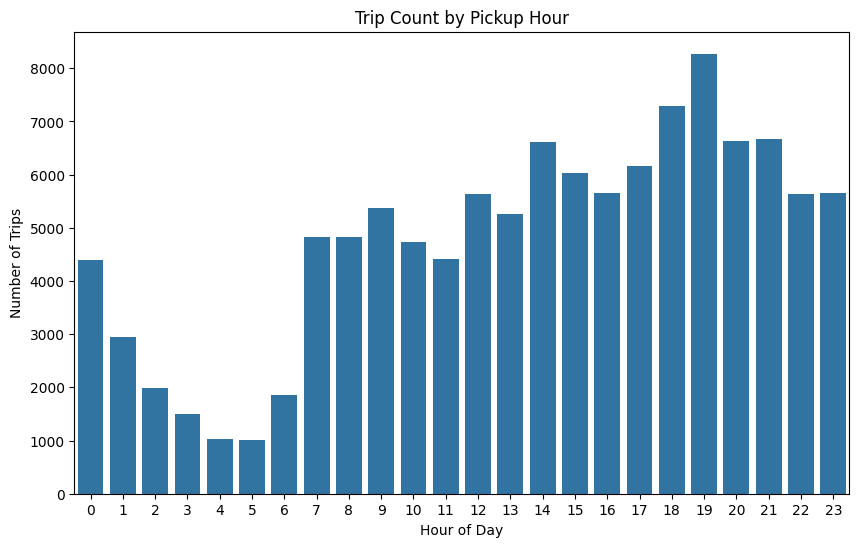

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(x="pickup_hour", y="trip_count", data=pandas_df)
plt.title("Trip Count by Pickup Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.show()


** Average Fare per Passenger Count**

In [27]:
df_passenger = df_cleaned.groupBy("passenger_count") \
    .agg(avg("total_amount").alias("avg_fare"), count("*").alias("trip_count")) \
    .orderBy("passenger_count")
df_passenger.show()

+---------------+------------------+----------+
|passenger_count|          avg_fare|trip_count|
+---------------+------------------+----------+
|              0|13.370597014925375|        67|
|              1|14.648879103481534|     80846|
|              2| 15.53719369286493|     16299|
|              3|15.101434901878058|      4739|
|              4|15.092452243447163|      2251|
|              5|14.602242945183532|      6166|
|              6|14.911565281898957|      4044|
|              9|              10.6|         1|
+---------------+------------------+----------+



Text(0.5, 0, 'Passenger Count')

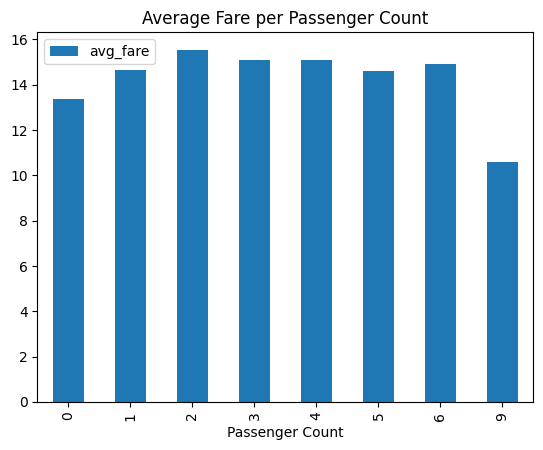

In [33]:
df_passenger.toPandas().plot(kind="bar", x="passenger_count", y="avg_fare", title="Average Fare per Passenger Count")
plt.xlabel("Passenger Count")


Trip Distance vs Fare Analysis
python
Copy code


In [29]:
df_distance = data.select("trip_distance", "total_amount").dropna()
df_distance = df_distance.filter((col("trip_distance") > 0) & (col("total_amount") > 0))

df_distance_stats = df_distance.agg(
    avg("trip_distance").alias("avg_distance"),
    avg("total_amount").alias("avg_fare")
)
df_distance_stats.show()


+------------------+------------------+
|      avg_distance|          avg_fare|
+------------------+------------------+
|2.7968160941789244|14.767940275927653|
+------------------+------------------+



**Top 5 Longest Trips (by Distance)**

In [31]:
df_longest = data.select("trip_distance", "total_amount", "tpep_pickup_datetime", "tpep_dropoff_datetime") \
               .orderBy(col("trip_distance").desc()) \
               .limit(5)
df_longest.show()

+-------------+------------+--------------------+---------------------+
|trip_distance|total_amount|tpep_pickup_datetime|tpep_dropoff_datetime|
+-------------+------------+--------------------+---------------------+
|        181.4|        9.13| 2015-01-30 07:33:53|  2015-01-30 09:25:10|
|         99.9|        27.3| 2015-01-17 14:25:46|  2015-01-17 14:50:16|
|         99.9|        8.63| 2015-01-15 07:32:49|  2015-01-15 08:48:25|
|        94.16|       58.13| 2015-01-29 11:59:17|  2015-01-29 17:23:49|
|         56.8|      270.13| 2015-01-09 14:25:56|  2015-01-09 15:47:24|
+-------------+------------+--------------------+---------------------+

